In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
events_data = pd.read_csv('event_data_train.csv')

In [4]:
submissions_data = pd.read_csv('submissions_data_train.csv')

In [6]:
events_data.head(10)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
5,32811,1434340895,passed,17632
6,32929,1434340921,discovered,17632
7,32929,1434340921,viewed,17632
8,32929,1434340939,started_attempt,17632
9,32929,1434340944,passed,17632


## поменяем формат времени в timestamp

In [6]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit = 's')

In [7]:
submissions_data['date'] = pd.to_datetime(events_data.timestamp, unit = 's')

In [9]:
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [9]:
events_data['day'] = events_data.date.dt.date

In [8]:
submissions_data['day'] = events_data.date.dt.date

In [13]:
events_data

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15
...,...,...,...,...,...,...
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19


### График активности студентов

<Axes: xlabel='day'>

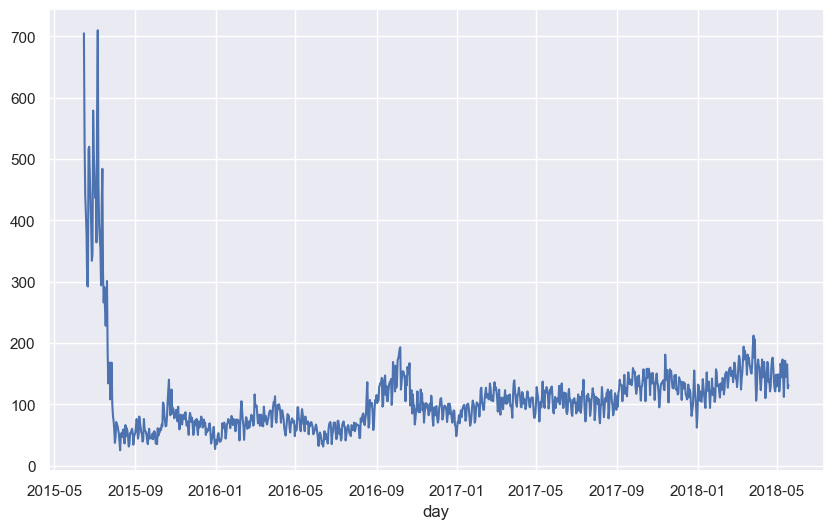

In [23]:
sns.set(rc = {'figure.figsize': (10,6)})
events_data.groupby('day').user_id.nunique().plot()

### Просмотрим число пройденных степов

Данный подход не учитывает тех пользователей которые не прошли ни одного степа

<Axes: >

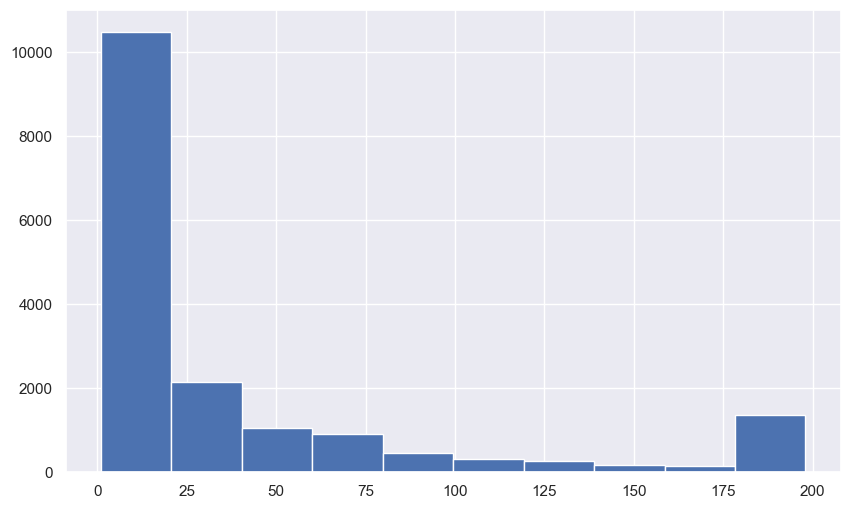

In [25]:
events_data[events_data.action == 'passed'].groupby('user_id').agg({'step_id': 'count'}, as_index = False)\
.rename(columns = {'step_id': 'passed_steps'}).passed_steps.hist()

Сделаем учет тех пользователей, которые мы могли выкинуть на предыдущем шаге.

In [36]:
events_data.pivot_table(index = 'user_id',
                        columns = 'action',
                        values = 'step_id',
                        aggfunc = 'count',
                        fill_value = 0)

SyntaxError: invalid syntax (427819742.py, line 5)

<Axes: >

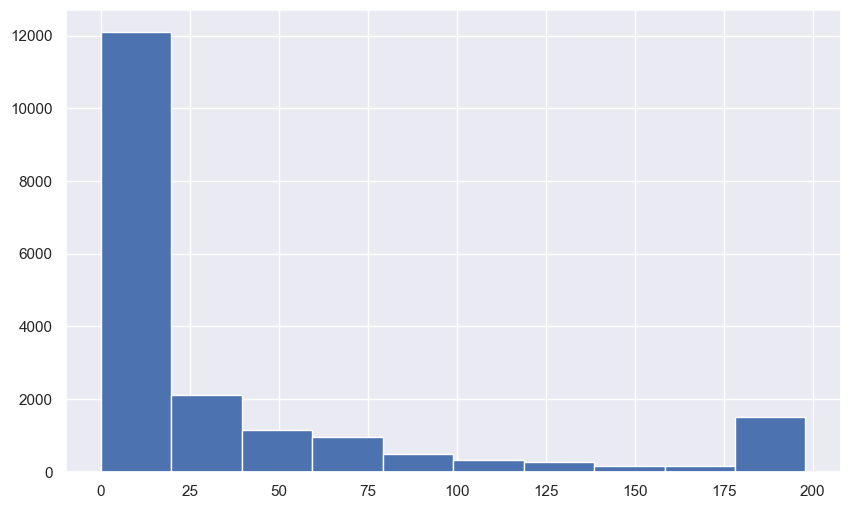

In [31]:
events_data.pivot_table(index = 'user_id',
                        columns = 'action',
                        values = 'step_id',
                        aggfunc = 'count',
                        fill_value = 0).discovered.hist()

### Получим колличество правильных и неправильных сабмитов

In [11]:
users_scores = submissions_data.pivot_table(index = 'user_id',
                        columns = 'submission_status',
                        values = 'step_id',
                        aggfunc = 'count',
                        fill_value = 0).reset_index()

In [12]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


<Axes: >

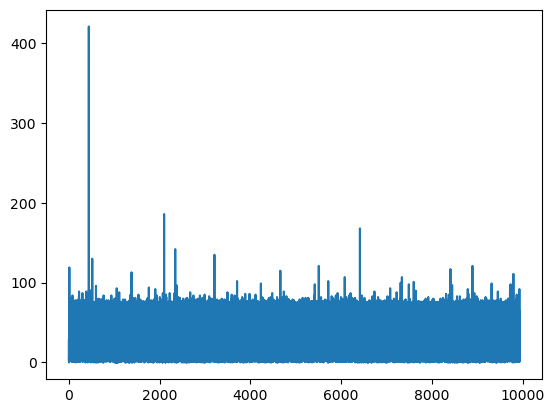

In [16]:
users_scores.correct.plot()

In [62]:
gap_date = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset = ['user_id', 'day']).groupby('user_id')['timestamp'] \
.apply(list).apply(np.diff).values

gap_date = pd.Series(np.concatenate(gap_date, axis = 0))

In [63]:
gap_date = gap_date / (24 * 3600)

<Axes: >

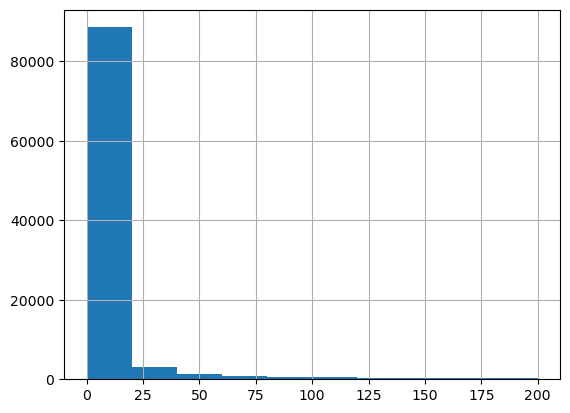

In [64]:
gap_date[gap_date < 200].hist()

In [68]:
per = 0.99
print( f'{per*100}% пользователей не возвращалось на курс больше чем {np.round(gap_date.quantile(per),0)} дней')

99.0% пользователей не возвращалось на курс больше чем 295.0 дней


### Найти id пользователя, который чаще всего просматривал степы.

In [74]:
gap_date = events_data.pivot_table(index = 'user_id',
                        columns = 'action',
                        values = 'step_id',
                        aggfunc = 'count',
                        fill_value = 0).reset_index()

gap_date

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1
...,...,...,...,...,...
19229,26790,8,8,1,9
19230,26793,1,0,1,1
19231,26794,69,69,34,180
19232,26797,10,10,2,13


In [84]:
gap_date[['user_id', 'viewed']].drop_duplicates(subset = ['user_id', 'viewed']).sort_values(by=['viewed'], ascending=False).reset_index().head(10)

action,index,user_id,viewed
0,15007,20907,32778
1,7780,10794,16089
2,18150,25279,9693
3,781,1046,8122
4,2611,3572,6968
5,8470,11770,6330
6,6879,9546,5915
7,553,761,4281
8,6043,8363,3492
9,4904,6764,2960


In [96]:
submissions_data[submissions_data.submission_status == 'correct'].groupby('user_id').agg ({'submission_status':'count'}).sort_values(by=['submission_status'], ascending=False).head(20)

,submission_status
user_id,
1046,421
5552,186
17135,168
6183,142
8461,135
1218,130
24022,121
14699,121
30,119


Правильный ответ 1046

### Проверим пользователей по критерию бросания

In [87]:
users_data = events_data.groupby('user_id', as_index = False).agg({'timestamp': 'max'}).rename(columns = {'timestamp' : 'last_timestamp'})

In [92]:
now = 1526772811
drop_out_threhold = 259200

In [93]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threhold

In [94]:
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True
